# Análisis Exploratorio &rarr; Tabla Ingresos

En este notebook se creó un análisis inicial a la tabla ingresos, con el fin de encontrar patrones en las ventas del negocio. También servirá para mejorar la pipeline de datos, especialmente la etapa de transformación de datos.

También se realizará un análisis a las tablas relacionadas (dependientes) como clientes, productos_ventas, acompañamientos, extras.

In [1]:
# Importe de librerías
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from dotenv import load_dotenv

In [2]:
# Carga de archivo

load_dotenv()
PATH = os.getenv('RUTA_INGRESOS')

df = pd.read_csv(PATH)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.head(5)

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Tipo,id_cliente,id_producto,id_acompañamiento,id_extra,Año,Mes,Trimestre,MesNombre,Semana,Dia,DiaAño,DiaSemana
0,0,2022-07-02,1.0,4000.0,0.0,4000.0,ALMUERZOS,0,65.0,0,0,2022,7,3,Jul,26,2,183,Saturday
1,1,2022-07-02,1.0,4000.0,0.0,4000.0,ALMUERZOS,1,65.0,0,0,2022,7,3,Jul,26,2,183,Saturday
2,1,2022-07-02,1.0,4000.0,0.0,4000.0,ALMUERZOS,1,60.0,1,1,2022,7,3,Jul,26,2,183,Saturday
3,2,2022-07-02,2.0,4000.0,0.0,8000.0,ALMUERZOS,2,65.0,2,0,2022,7,3,Jul,26,2,183,Saturday
4,3,2022-07-03,3.0,4000.0,0.0,12000.0,ALMUERZOS,3,6.0,3,0,2022,7,3,Jul,26,3,184,Sunday


## Información de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Boleta             2471 non-null   int64         
 1   Fecha              2471 non-null   datetime64[ns]
 2   Cantidad           2471 non-null   float64       
 3   Precio             2471 non-null   float64       
 4   Descuento          2471 non-null   float64       
 5   Total              2471 non-null   float64       
 6   Tipo               2471 non-null   object        
 7   id_cliente         2471 non-null   int64         
 8   id_producto        2471 non-null   float64       
 9   id_acompañamiento  2471 non-null   int64         
 10  id_extra           2471 non-null   int64         
 11  Año                2471 non-null   int64         
 12  Mes                2471 non-null   int64         
 13  Trimestre          2471 non-null   int64         
 14  MesNombr

In [4]:
'''
De la ejecución anterior se puede apreciar que existe un total de 2470 filas y en las columnas Precio, Descuento y Total 
existen nulos, por lo que, a continuación se desarrollaran distintos métodos para reemplazar 
los nulos de las columnas mencionadas.
'''

df1 = df[ (df['Descuento'].isna()) |  (df['Total'].isna()) | (df['Precio'].isna())].copy() # subconsulta con los nulos

df_precios_na = df1[(df1['Precio'].isna())]
df_dsctos_na = df1[(df1['Descuento'].isna())]
df_total_na = df1[(df1['Total'].isna())]

In [5]:
df_precios_na

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Tipo,id_cliente,id_producto,id_acompañamiento,id_extra,Año,Mes,Trimestre,MesNombre,Semana,Dia,DiaAño,DiaSemana


In [6]:
# Ya se actualizó la pipeline con la función anterior, por lo que, no hay nulos hasta el momento
# Algoritmo de arreglo para precios nulos para otros ingresos

'''
Para reemplazar los precios nulos, se creará un algoritmo que buscará los precios más paracidos en un rango de una semana,
se debe coincidir las cantidad de productos vendidos, si existe más de un precio en el rango de fechas, 
se utilizará el promedio, en caso contrario, se utilizará el precio único. 
'''

def calcular_precios_cercanos(df, columna_precio):
    precios = df[columna_precio].to_list()
    precios = [precio for precio in precios if precio > 0]

    if len(precios) > 1:
        return sum(precios)/len(precios)
    
    elif len(precios) == 1:
        return precios[0]

    else: 
        # Buscar rangos de fechas más largos
        return 0
    

df2 = df_precios_na.copy()
indices_precios_na = df2.index.to_list()
cantidades = df2.loc[indices_precios_na, 'Cantidad'].to_list()
productos = df2.loc[indices_precios_na, 'id_producto'].to_list()

datos = []

for i in range(len(productos)):
    df3 = df2[(df2['id_producto']==productos[i])]
    indice = df3.index.to_list()
    
    fecha = df2.loc[indice, 'Fecha'].to_list()
    fecha_min = fecha[0] - timedelta(7)
    fecha_max = fecha[0] + timedelta(7)

    df4 = df.copy()

    condicion1 = df4['id_producto'].isin(productos)
    condicion2 = df4['Fecha'] > fecha_min
    condicion3 = df4['Fecha'] < fecha_max
    condicion4 = df4['Cantidad'].isin(cantidades)

    df4 = df4[(condicion1) & (condicion2) & (condicion3) & (condicion4)]
    precio_final = 0

    if df4.empty:
        df4 = df.copy()
        df4 = df4[(condicion1) & (condicion2) & (condicion3)]

        precio_final = calcular_precios_cercanos(df4, 'Precio')

    else:
        precio_final = calcular_precios_cercanos(df4, 'Precio')

    datos.append({
            'Indice':indice[0],
            'id_producto': productos[i],
            'Precio': precio_final
        })

datos = pd.DataFrame(datos)


if not datos.empty:

    datos = datos.set_index('Indice')

    df1.loc[datos.index.to_list(), ['Principal-Producto', 'Precio']] = datos

    print('Precios nulos corregidos')
    df1.loc[datos.index, :]



In [7]:
# Descuentos y Total nulos

''' En este df existe un error particular, donde un dato después del numero viene un }, 
    así que este error será reemplazado y los otros nulos serán reemplazados por 0. 
    Por otro lado, la columna total tiene un único valor nulo que tiene relación con el dato de dscto con }.
'''
# df1.loc[:,('Descuento')] = df1.loc[:, ('Descuento')].str.replace('}', '', regex=True)
# df1['Descuento'] = df1['Descuento'].fillna(0)

# df1['Descuento'] = df1['Descuento'].astype(float)

# df1['Total'] = (df1['Cantidad'] * df1['Precio']) - df1['Descuento']


' En este df existe un error particular, donde un dato después del numero viene un }, \n    así que este error será reemplazado y los otros nulos serán reemplazados por 0. \n    Por otro lado, la columna total tiene un único valor nulo que tiene relación con el dato de dscto con }.\n'

In [8]:
# reemplazar valores df1 en df

df.loc[df1.index.to_list(), :] = df1

df['Descuento'] = df['Descuento'].astype(float)
df['id_cliente'] = df['id_cliente'].astype(str)
df['id_producto'] = df['id_producto'].astype(str)
df['id_acompañamiento'] = df['id_acompañamiento'].astype(str)
df['id_extra'] = df['id_extra'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Boleta             2471 non-null   int64         
 1   Fecha              2471 non-null   datetime64[ns]
 2   Cantidad           2471 non-null   float64       
 3   Precio             2471 non-null   float64       
 4   Descuento          2471 non-null   float64       
 5   Total              2471 non-null   float64       
 6   Tipo               2471 non-null   object        
 7   id_cliente         2471 non-null   object        
 8   id_producto        2471 non-null   object        
 9   id_acompañamiento  2471 non-null   object        
 10  id_extra           2471 non-null   object        
 11  Año                2471 non-null   int64         
 12  Mes                2471 non-null   int64         
 13  Trimestre          2471 non-null   int64         
 14  MesNombr

## Análisis de los datos

In [9]:
df.describe()

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Año,Mes,Trimestre,Semana,Dia,DiaAño
count,2471.000000,2471,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,810.205585,2023-07-25 18:42:23.747470592,1.851882,4754.723837,6.475111,6402.928207,2022.985836,7.485229,2.810603,30.499798,15.532983,211.949413
min,0.000000,2022-07-02 00:00:00,1.000000,300.000000,0.000000,1000.000000,2022.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,408.500000,2023-05-12 00:00:00,1.000000,5000.000000,0.000000,5000.000000,2023.000000,5.000000,2.000000,20.000000,8.000000,139.500000
50%,817.000000,2023-08-09 00:00:00,1.000000,5000.000000,0.000000,5000.000000,2023.000000,8.000000,3.000000,32.000000,15.000000,219.000000
75%,1213.000000,2023-10-22 00:00:00,2.000000,5000.000000,0.000000,6000.000000,2023.000000,10.000000,4.000000,42.000000,23.000000,294.000000
max,1633.000000,2024-01-05 00:00:00,36.000000,7500.000000,1000.000000,69600.000000,2024.000000,12.000000,4.000000,52.000000,31.000000,365.000000
std,463.988459,NaN,2.817512,1235.799667,80.223368,3458.156114,0.215309,3.195848,1.050807,13.999910,8.916551,97.916292


In [10]:
def indicadores_ingresos(df, periodo_tiempo, Categorizar=False, fecha_inicio=None, fecha_fin=None):
    
    # Definir valores predeterminados para fecha_inicio y fecha_fin si no se proporcionan
    if fecha_inicio is None:
        fecha_inicio = df['Fecha'].min()
    if fecha_fin is None:
        fecha_fin = df['Fecha'].max()

    # Definir columnas a filtrar y a agrupar
    filtrar = [periodo_tiempo, 'Total', 'id_cliente', 'Boleta', 'Cantidad', 'id_producto']
    agrupar = [periodo_tiempo]

    # Actualizar si se va a categorizar
    if Categorizar:
        agrupar.append('Tipo')
        filtrar.append('Tipo')

    # Filtrar el DataFrame
    df_filtrado = df[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin)]
    
    # Realizar agrupación y cálculos de indicadores
    df_indicadores = df_filtrado[filtrar].groupby(agrupar).agg({
        'Total': 'sum',
        'id_cliente': 'nunique',
        'Boleta': 'nunique',
        'Cantidad': 'sum',
        'id_producto': 'nunique'
    })

    # Renombrar columnas
    df_indicadores = df_indicadores.rename(columns={'id_cliente': 'N°_Clientes', 'id_producto': 'N°_Productos'})

    # Calcular indicadores adicionales
    df_indicadores['Ticket_Promedio'] = df_indicadores['Total'] / df_indicadores['Boleta']
    df_indicadores['Productos_Boleta'] = df_indicadores['Cantidad'] / df_indicadores['Boleta']
    df_indicadores['Gasto_Cliente'] = df_indicadores['Total'] / df_indicadores['N°_Clientes']

    # Resetear el índice para obtener una estructura de DataFrame más plana
    return df_indicadores.reset_index(), Categorizar

def graficar_indicadores(df_indicadores, periodo_tiempo, Categorizar = False):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

    if Categorizar: 
        almuerzos = df_indicadores[df_indicadores['Tipo']=='ALMUERZOS']
        otros = df_indicadores[df_indicadores['Tipo']=='OTROS']

        ax1.plot(almuerzos[periodo_tiempo], almuerzos['Total']/1000000.0, color='red', marker='o', label='Almuerzos')
        ax1.plot(otros[periodo_tiempo], otros['Total']/1000000.0, color='black', marker='x', label='Otros')
        ax1.legend(loc = 'upper left')

        ax2.plot(almuerzos[periodo_tiempo], almuerzos['Ticket_Promedio'], color='red', marker='o', label='Almuerzos')
        ax2.plot(otros[periodo_tiempo], otros['Ticket_Promedio'], color='black', marker='x', label='Otros')
        ax2.legend(loc = 'upper left')

        ax3.plot(almuerzos[periodo_tiempo], almuerzos['N°_Clientes'], color='red', marker='o', label='Almuerzos')
        ax3.plot(otros[periodo_tiempo], otros['N°_Clientes'], color='black', marker='x', label='Otros')
        ax3.legend(loc = 'upper left')
        

    else:
        ax1.plot(df_indicadores[periodo_tiempo], df_indicadores['Total']/1000000.0, color='red', marker='o', label='Total')
        ax2.plot(df_indicadores[periodo_tiempo], df_indicadores['Ticket_Promedio'], color='blue')
        ax3.plot(df_indicadores[periodo_tiempo], df_indicadores['N°_Clientes'], color='green')
        
        
    ax1.set_title(f'Ingresos por {periodo_tiempo}')
    ax1.set_xlabel(f'{periodo_tiempo}')
    ax1.set_ylabel('Ingresos (Mill)')
    
    ax2.set_title(f'Ticket Promedio por {periodo_tiempo}')
    ax2.set_xlabel(f'{periodo_tiempo}')
    ax2.set_ylabel('Ticket Promedio')
    
    ax3.set_title(f'Número de Clientes por {periodo_tiempo}')
    ax3.set_xlabel(f'{periodo_tiempo}')
    ax3.set_ylabel('Clientes')

    plt.tight_layout()
    plt.show()


In [11]:
# Estadisticas Generales periodo 2023

fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df1 = df[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin)]

df2 = df1[['Fecha','Total']].groupby('Fecha').sum().reset_index()

ingresos = df1['Total'].sum()
dias = df1['Fecha'].nunique()
clientes = df1['id_cliente'].nunique()
almuerzos_qty = df1[df1['Tipo']=='ALMUERZOS']['Cantidad'].sum()
almuerzos_ing = df1[df1['Tipo']=='ALMUERZOS']['Total'].sum()

menor_ingreso = df2[df2['Total']==df2['Total'].min()]['Total'].sum()
menor_fecha = df2[df2['Total']==df2['Total'].min()]['Fecha'].max()
mayor_ingreso = df2[df2['Total']==df2['Total'].max()]['Total'].sum()
mayor_fecha = df2[df2['Total']==df2['Total'].max()]['Fecha'].max()

print('RESUMEN 2023')
print(f'Ingresos Totales: ${int(ingresos):,}')
print(f'Ingresos por Almuerzos: ${int(almuerzos_ing):,} ({((100*almuerzos_ing)/ingresos): .2f}% del total )')
print(f'Ingresos por Otros: ${int(ingresos - almuerzos_ing):,} ({((100*(ingresos - almuerzos_ing))/ingresos): .2f}% del total )')
print(f'Días trabajados: {dias} ({((100*dias)/365): .2f}% del año )')
print(f'Total de Clientes: {clientes}')
print(f'Almuerzos vendidos: {int(almuerzos_qty):,}')
print('------------------------------------------------------')
print(f'El día con menor ingresos fue {menor_fecha} con ${int(menor_ingreso):,}')
print(f'El día con mayor ingresos fue {mayor_fecha} con ${int(mayor_ingreso):,}')



RESUMEN 2023
Ingresos Totales: $14,962,135
Ingresos por Almuerzos: $13,664,500 ( 91.33% del total )
Ingresos por Otros: $1,297,635 ( 8.67% del total )
Días trabajados: 336 ( 92.05% del año )
Total de Clientes: 215
Almuerzos vendidos: 2,668
------------------------------------------------------
El día con menor ingresos fue 2023-05-04 00:00:00 con $4,000
El día con mayor ingresos fue 2023-10-21 00:00:00 con $149,000


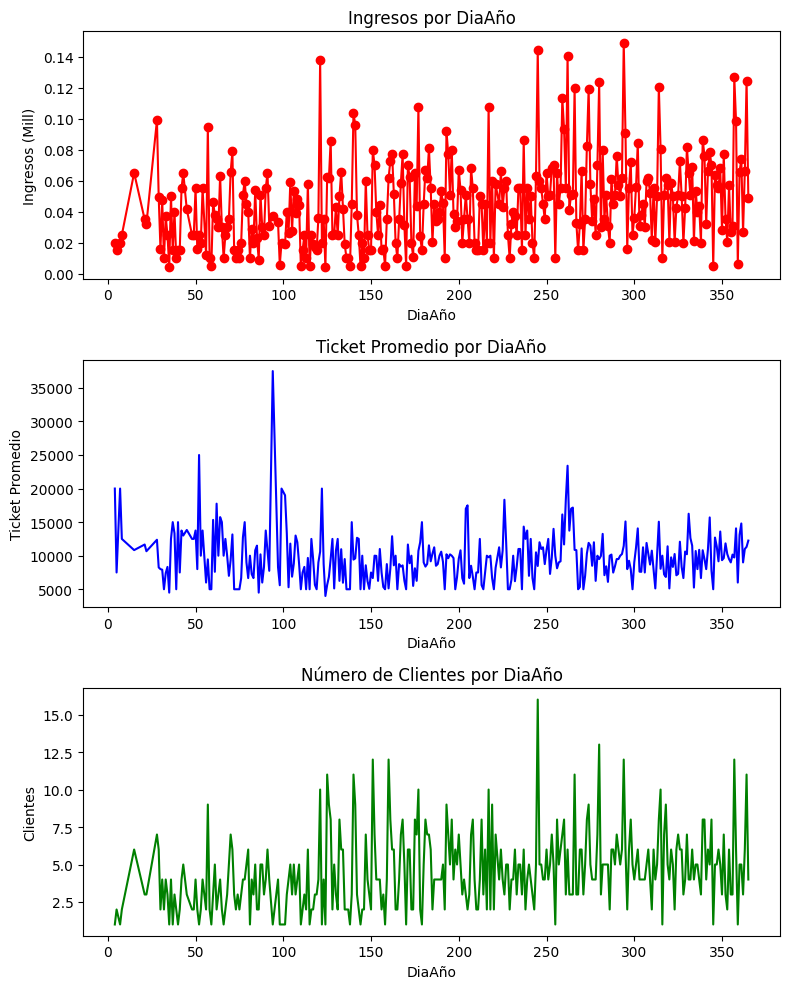

In [12]:
# Mostrar indicadores Diarios 2023

periodo_tiempo = 'DiaAño'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores, categorizar = indicadores_ingresos(df, periodo_tiempo, False, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo, categorizar)



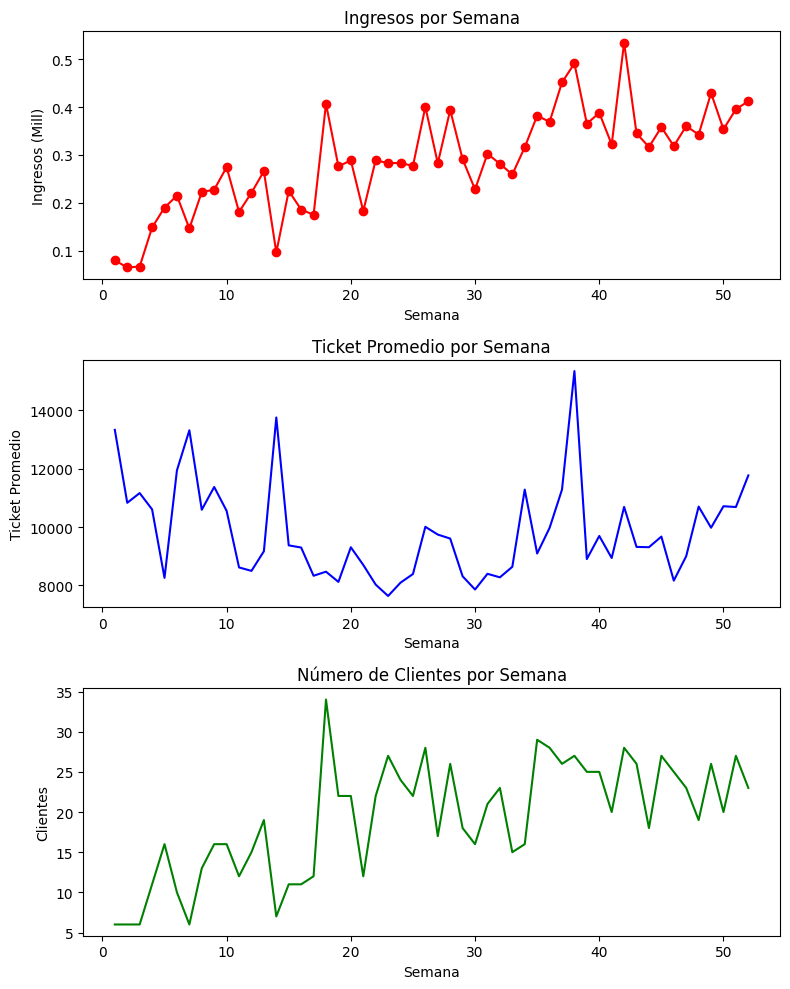

In [13]:
# Mostrar indicadores Semanales 2023

periodo_tiempo = 'Semana'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores, categorizar = indicadores_ingresos(df, periodo_tiempo, False, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo, categorizar)


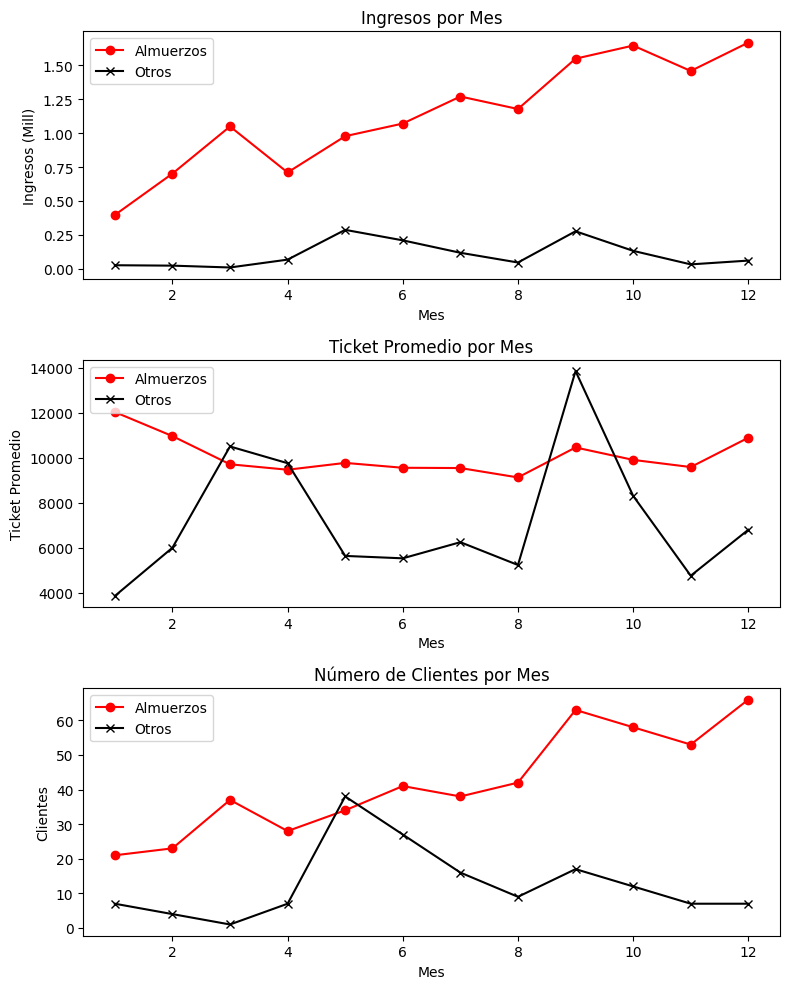

In [14]:
# Mostrar indicadores Mensuales 2023

periodo_tiempo = 'Mes'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores, categorizar = indicadores_ingresos(df, periodo_tiempo, True, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo, categorizar)


## Conclusiones

A pesar de una mirada bastante simple de los ingresos, se pudo obtener una idea general del cambio de los datos a lo largo del periodo 2023, también ayudará a mejorar el procesos de la ETL, especialmente con las funciones creadas e incluso algunos cambios de tipo de las columnas. 

Por otro lado, en el resumen de 2023 se identifico que más del 90% de los ingresos totales pertenecen a los almuerzos...  

# Análisis Exploratorio &rarr; Tablas dependientes

Actualmente las tablas relacionadas a Ingresos son:

1. Clientes &rarr; id_cliente - nombre
2. Productos_Ventas &rarr; nombre - id_producto - categoría
3. Acompañamientos &rarr; id_acompañamiento - nombre
4. Extras &rarr; id_extra - nombre



## Clientes

Se incorporarán distintos indicadores para entender los comportamientos de estos clientes y poder facilitar la segmentación de clientes con algún algoritmo de agrupamiento de ML, las columnas a añadir serán: 

* Primera y última compra ✅
* compra máxima y mínima ✅
* cantidad de almuerzos y otros pedidos ✅
* gasto total y por tipo ✅
* almuerzo o producto, acompañamiento y extra preferidos. ✅
* frecuencia de compra en dias ✅
* ticket promedio ✅

Por otro lado, se realizará un ánalisis de pareto para comprender el impacto del gasto de cada cliente, en los ingresos totales del 2023


In [15]:
PATH = os.getenv('RUTA_CLIENTES')
clientes = pd.read_csv(PATH)

def encontrar_favoritos(lista):
    datos = pd.Series(lista).value_counts().reset_index().rename(columns={'index': 'id', 0: 'cantidad'})

    return float(datos.iloc[0, 0])

def indicadores_clientes(clientes, ingresos, Año=None):

    df = ingresos.copy()

    if not Año is None:
        df = df[df['Año']==Año]

    df1 = df[['Boleta','Fecha','id_cliente','Tipo','id_producto','id_acompañamiento','id_extra','Cantidad','Total']]

    for id, df2 in df1.groupby('id_cliente'): #
              
        fechas = set(df2['Fecha'].to_list())

        if len(fechas)>1:

            fechas = pd.DataFrame(fechas).rename(columns={0:'Fecha'}).sort_values('Fecha').reset_index().drop(columns='index')
            fechas['Dif'] = fechas['Fecha'].diff().dt.days

            dif_fechas = fechas['Dif'].sum()/(fechas.shape[0] - 1)
        
        else: 
            dif_fechas = 0.


        id = int(id)

        clientes.loc[id, 'primera_compra'] = df2['Fecha'].min()
        clientes.loc[id, 'ultima_compra'] = df2['Fecha'].max()

        df3 = df2[['Fecha','Boleta','Total']].groupby(['Boleta','Fecha']).sum().reset_index()
        clientes.loc[id, 'compra_minima'] = df3['Total'].min()
        clientes.loc[id, 'compra_maxima'] = df3['Total'].max()
        clientes.loc[id, 'gasto_total'] = df3['Total'].sum()
        clientes.loc[id, 'boletas'] = df3['Boleta'].nunique()

        almuerzos = df2[df2['Tipo']=='ALMUERZOS']

        if not almuerzos.empty:
            clientes.loc[id, 'gasto_almuerzos'] = almuerzos['Total'].sum()
            clientes.loc[id, 'cantidad_almuerzos'] = almuerzos['Cantidad'].sum()
        
        else:
            clientes.loc[id, 'gasto_almuerzos'] = 0
            clientes.loc[id, 'cantidad_almuerzos'] = 0

        otros = df2[df2['Tipo']=='OTROS']

        if not otros.empty:
            clientes.loc[id, 'gasto_otros'] = otros['Total'].sum()
            clientes.loc[id, 'cantidad_otros'] = otros['Cantidad'].sum()
        
        else:
            clientes.loc[id, 'gasto_otros'] = 0
            clientes.loc[id, 'cantidad_otros'] = 0

        productos_favoritos = df2['id_producto'].to_list()
        acompañamientos_favoritos = df2['id_acompañamiento'].to_list()
        extras_favoritos = df2['id_extra'].to_list()

        clientes.loc[id, 'producto_favorito'] = encontrar_favoritos(productos_favoritos)
        clientes.loc[id, 'acompañamiento_favorito'] = encontrar_favoritos(acompañamientos_favoritos)
        clientes.loc[id, 'extra_favorito'] = encontrar_favoritos(extras_favoritos)
        clientes.loc[id, 'frecuencia_compra_dif'] = dif_fechas

    clientes['tiempo_cliente'] = (clientes['ultima_compra'] - clientes['primera_compra']).dt.days
    clientes['frecuencia_compra_resta'] = (clientes['tiempo_cliente'])/clientes['boletas']
    clientes['ticket_promedio'] = clientes['gasto_total']/clientes['boletas']
        
    return clientes.dropna()

clientes = indicadores_clientes(clientes, df, 2023)
clientes


,id_cliente,Cliente,primera_compra,ultima_compra,compra_minima,compra_maxima,gasto_total,boletas,gasto_almuerzos,cantidad_almuerzos,gasto_otros,cantidad_otros,producto_favorito,acompañamiento_favorito,extra_favorito,frecuencia_compra_dif,tiempo_cliente,frecuencia_compra_resta,ticket_promedio
0,0,JUAN,2023-04-24,2023-04-28,5000.0,6000.0,11000.0,2.0,11000.0,2.0,0.0,0.0,69.0,7.0,0.0,4.000000,4.0,2.000000,5500.000000
1,1,DON ROBERTO,2023-01-07,2023-12-23,2799.6,20000.0,357298.8,48.0,326000.0,64.0,31298.8,31.0,3.0,3.0,4.0,8.333333,350.0,7.291667,7443.725000
2,2,JORGE,2023-01-05,2023-12-29,1500.0,18000.0,466800.2,47.0,443000.0,92.0,23800.2,17.0,62.0,3.0,0.0,8.523810,358.0,7.617021,9931.919149
3,3,KATYA,2023-01-22,2023-10-01,5000.0,22000.0,149900.0,13.0,138500.0,26.0,11400.0,4.0,0.0,3.0,0.0,21.000000,252.0,19.384615,11530.769231
4,4,LEDY,2023-01-05,2023-12-19,4200.0,25000.0,386200.0,33.0,382000.0,74.0,4200.0,12.0,0.0,3.0,4.0,10.875000,348.0,10.545455,11703.030303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,213,DIEGO PONCE,2023-09-20,2023-09-20,7200.0,7200.0,7200.0,1.0,0.0,0.0,7200.0,3.0,166.0,3.0,3.0,0.000000,0.0,0.000000,7200.000000
214,214,CLAUDIA (VECINA),2023-09-20,2023-09-20,12000.0,12000.0,12000.0,1.0,0.0,0.0,12000.0,5.0,166.0,3.0,3.0,0.000000,0.0,0.000000,12000.000000
215,215,GEYSI,2023-09-23,2023-11-20,1000.0,2000.0,3000.0,2.0,0.0,0.0,3000.0,3.0,176.0,3.0,3.0,58.000000,58.0,29.000000,1500.000000
216,216,LORENA SILVA,2023-10-01,2023-10-01,14800.0,14800.0,14800.0,1.0,0.0,0.0,14800.0,6.0,191.0,3.0,3.0,0.000000,0.0,0.000000,14800.000000


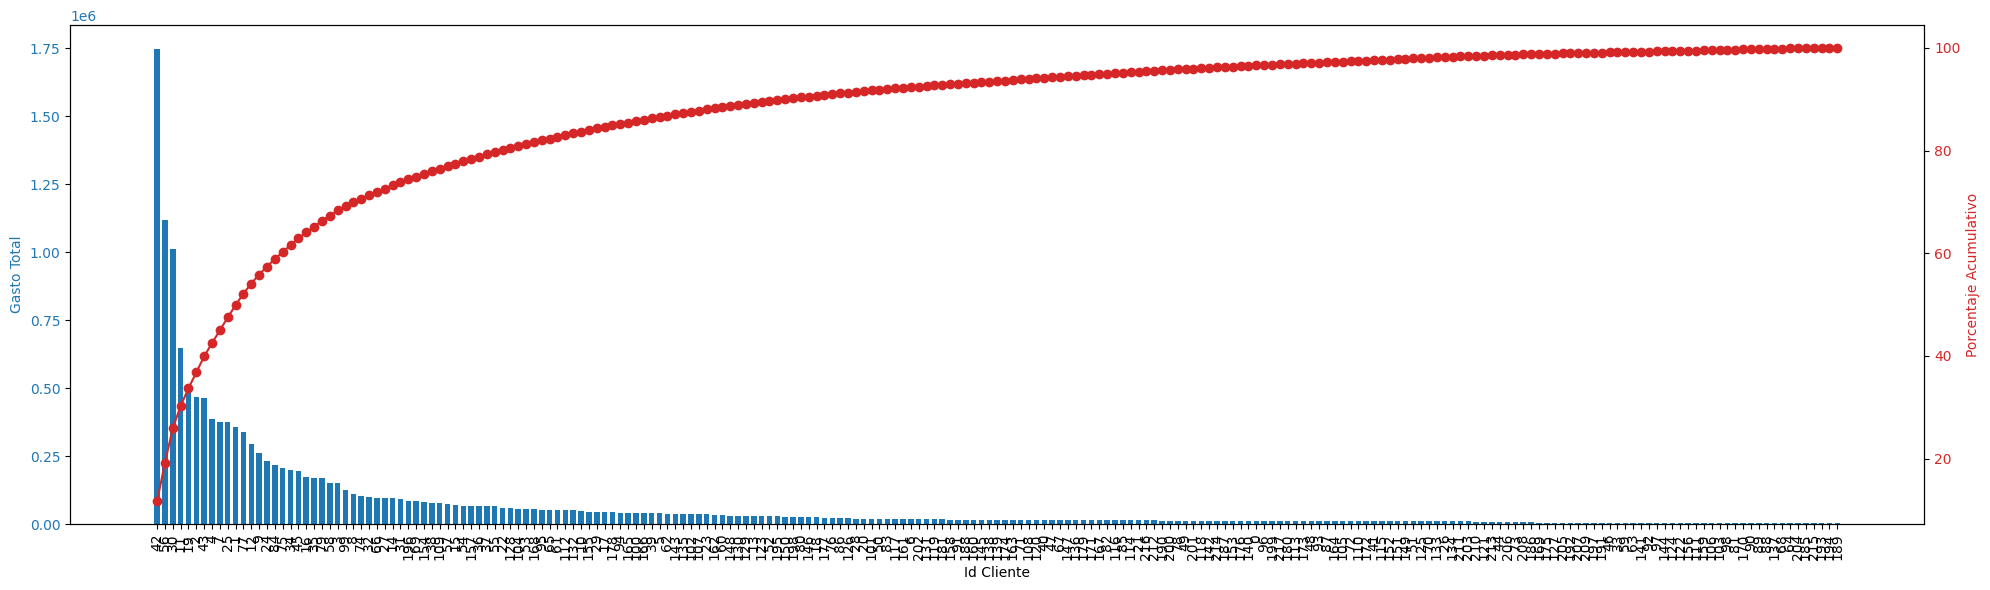

In [16]:
pareto = clientes[['id_cliente','Cliente','gasto_total']]
pareto = pareto.sort_values(by='gasto_total', ascending=False)
pareto['gasto_acumulado'] = pareto['gasto_total'].cumsum()

pareto['porcentaje'] = (pareto['gasto_acumulado']/pareto['gasto_total'].sum()) * 100 
pareto['id_cliente'] = pareto['id_cliente'].astype(str)

# pareto1 = pareto.head(50)

fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

color = 'tab:blue'
ax1.bar(pareto['id_cliente'], pareto['gasto_total'], color=color, width=0.7)
ax1.set_xlabel('Id Cliente')
ax1.set_xticks(range(pareto.shape[0]))
ax1.set_xticklabels(pareto['id_cliente'], rotation=90, ha='center')
ax1.set_ylabel('Gasto Total', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(pareto['id_cliente'], pareto['porcentaje'], color=color,  marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje Acumulativo', color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()

clientes_20_porc = pareto[pareto['porcentaje']<=80].shape[0]
plt.show()


# print(clientes_20_porc/pareto.shape[0])

## Productos_Ventas

Ya que vendemos comida casera es un poco complicado realizar un cruce, entre todos los productos que compramos con los que vendemos, pero donde si ocurre esto es los envases, cada almuerzo vendido debe ser entregado en un envase, para la mayoría de almuerzos utilizamos Marmitas, para lasañas y pasteles se utilizan envases C-18, y los zapallos italianos en envases CT5.

Dejare valores nulos para la categoría OTROS en este análisis, porque variamos los envases en la entrega de este tipo de productos.

In [17]:
PATH = os.getenv('RUTA_PRODUCTOS_VENTA')
productos_ventas = pd.read_csv(PATH)

# MARMITAS : 3, C-18: 7, CT5: 141

productos_ventas['Envase'] = np.nan

ct5 = productos_ventas[productos_ventas['Producto']=='ZAPALLO ITALIANO'].index
productos_ventas.loc[ct5, 'Envase'] = 141

c18 = productos_ventas[(productos_ventas['Producto'].str.startswith('LASAÑA')) | (productos_ventas['Categoria']=='PASTELES')].index
productos_ventas.loc[c18, 'Envase'] = 7

marmitas = productos_ventas[(productos_ventas['Envase'].isna()) & (productos_ventas['Categoria'] != 'OTROS')].index
productos_ventas.loc[marmitas, 'Envase'] = 3

productos_ventas


,Producto,id_producto,Categoria,Envase
0,PASTEL DE CHOCLO,0.0,PASTELES,7.0
1,MILANESA NORMAL,1.0,CARNES,3.0
2,MIX ENSALADA,2.0,ENSALADAS,3.0
3,PASTEL DE PAPA,3.0,PASTELES,7.0
4,CARBONADA,4.0,SOPAS,3.0
...,...,...,...,...
104,EMPANADA NAPOLITANA,191.0,OTROS,NaN
105,EMAPANADA PINO,192.0,OTROS,NaN
106,PORCIÓN COSTILLAR,193.0,OTROS,NaN
107,EMAPANADA MARISCO,194.0,OTROS,NaN
